In [ ]:
# TO DO:
# General: add second leg, etc.
#Abs Specific: fix angle constraints and figure out whether torques are influenced by angle setup

In [1]:
# DERIVE THE EOMs SYMBOLICALLY -------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np
import multiprocessing as mp #multiprocessing, just for the simplification steps
import time # for benchmarking different models

sym.init_printing()
from IPython.display import display #for pretty printing

# define non--program-critical functions
def log_time(t_start=None, msg=""):
    t_end = time.perf_counter()
    if t_start == None: print("Timer initialized")
    else: print(msg + f": {t_end - t_start:.6f} sec")
    return t_end

def mp_trigsimp(m):
    mp_data = [(m[r,c]) for r in range(m.rows) for c in range(m.cols)]
    if __name__ == '__main__':
        p = mp.Pool()
        results = p.map(sym.trigsimp, mp_data)
        p.close()
        p.join()
    return sym.Matrix(results).reshape(m.rows,m.cols)

# ------------------------------------------------------------------------------------------------------------------
# create symbolic variables

# system parameters 
g = sym.symbols('g')
m1, l1, In1, d1 = sym.symbols(['m_{1}','l_{1}','I_{1}','d_{1}'])
m2, l2, In2, d2 = sym.symbols(['m_{2}','l_{2}','I_{2}','d_{2}'])
m3, l3, In3, d3 = sym.symbols(['m_{3}','l_{3}','I_{3}','d_{3}'])
m4, l4, In4, d4 = sym.symbols(['m_{4}','l_{4}','I_{4}','d_{4}'])



# generalized coordinates
x  ,  dx,  ddx = sym.symbols(['x'          ,'\dot{x}'          ,'\ddot{x}'])
y  ,  dy,  ddy = sym.symbols(['y'          ,'\dot{y}'          ,'\ddot{y}'])
th1,dth1,ddth1 = sym.symbols(['\\theta_{1}','\dot{\\theta}_{1}','\ddot{\\theta}_{1}'])
th2,dth2,ddth2 = sym.symbols(['\\theta_{2}','\dot{\\theta}_{2}','\ddot{\\theta}_{2}'])
th3,dth3,ddth3 = sym.symbols(['\\theta_{3}','\dot{\\theta}_{3}','\ddot{\\theta}_{3}'])
th4,dth4,ddth4 = sym.symbols(['\\theta_{4}','\dot{\\theta}_{4}','\ddot{\\theta}_{4}'])

# q   = sym.Matrix([  [x],  [y],  [th1],  [th2],  [th3]])
# dq  = sym.Matrix([ [dx], [dy], [dth1], [dth2], [dth3]])
# ddq = sym.Matrix([[ddx],[ddy],[ddth1],[ddth2],[ddth3]])

q   = sym.Matrix([  [x],  [y],  [th1],  [th2],  [th3],  [th4]])
dq  = sym.Matrix([ [dx], [dy], [dth1], [dth2], [dth3], [dth4]])
ddq = sym.Matrix([[ddx],[ddy],[ddth1],[ddth2],[ddth3],[ddth4]])


# ------------------------------------------------------------------------------------------------------------------
# functions, # don't ask, they work for the purposes of this program
def WeirdRot(v, th):
    # weird rotation function for working with [x; y; th] vectors
    # usage: gives R_1^0 transformation, and adds the angle of rotation to result
    R = sym.Matrix([[sym.cos(th), -sym.sin(th), 0],
                    [sym.sin(th),  sym.cos(th), 0],
                    [       0,        0, 1]])
    S = sym.Matrix([[0],[0],[th]])
    return R*v + S

def WeirdAdd(v1, v2):
    # returns the sum of two vectors of the form [x; y; th]
    # both in the same ref. frame, preserving only the first angle
    v3 = sym.Matrix([[1],[1],[0]])
    return v1 + sym.matrix_multiply_elementwise(v3, v2)

def WeirdTrans(v1, ang1, off1, ang2=0, off2=sym.Matrix([[0],[0],[0]])):
    # ^ & ^ just like me
    # transforms [x,y,th] vector to inertial frame using position offsets and
    # rotation angles as specified
    rn_m = WeirdAdd(WeirdRot(v1, ang1),off1)
    rn_0 = WeirdAdd(WeirdRot(rn_m, ang2),off2)
    return rn_0


# ------------------------------------------------------------------------------------------------------------------
# mass positions, foot positions
r1_1 = sym.Matrix([[0],[0],[0]]) #sanity check
r1_0 = WeirdTrans(r1_1, th1, sym.Matrix([[x],[y],[0]]))

r2_2 = sym.Matrix([[0],[-l2*d2],[0]])
r2_0 = WeirdTrans(r2_2, th2-th1, r1_1, th1, r1_0) #sanity check

r3_3 = sym.Matrix([[0],[-l3*d3],[0]])
r3_0 = WeirdTrans(r3_3, th3-th2, r2_2*(1-d2)/d2, th2, r2_0)

r4_4 = sym.Matrix([[0],[-l4*d4],[0]]) # could define in x, but for consistency -y is fine
r4_0 = WeirdTrans(r4_4, th4-th3, r3_3*(1-d3)/d3, th3, r3_0)

rfoot_4 = sym.Matrix([[0],[-l4],[0]])
rfoot_0 = WeirdTrans(rfoot_4, th4-th3, r3_3*(1-d3)/d3, th3, r3_0) #divide by d3 to get full link length

# hopefully these speed up later simplifications
# update: simplifying here means no simplification needed in dr below (tested for dr3 and dr4).
# update 2: halves the simplification time of T
process_timer = log_time()
r2_0 = sym.trigsimp(r2_0)
r3_0 = sym.trigsimp(r3_0)
r4_0 = sym.trigsimp(r4_0)
rfoot_0 = sym.trigsimp(rfoot_0)
process_timer = log_time(process_timer, "Simplified 'r's")

# mass velocities, foot velocity
dr1 = r1_0.jacobian(q)*dq
dr2 = r2_0.jacobian(q)*dq
dr3 = r3_0.jacobian(q)*dq
dr4 = r4_0.jacobian(q)*dq
drfoot = rfoot_0.jacobian(q)*dq



# ------------------------------------------------------------------------------------------------------------------
# kinetic and potential energy
def Ek(m, In, dr):
    InM = sym.Matrix([[m,0,0],[0,m,0],[0,0,In]])
    return 0.5*dr.T*InM*dr

def Ep(m, r):
    return sym.Matrix([m*g*r[1]])

T = Ek(m1,In1,dr1) + Ek(m2,In2,dr2) + Ek(m3,In3,dr3) + Ek(m4,In4,dr4)
V = Ep(m1,r1_0) + Ep(m2,r2_0) + Ep(m3,r3_0) + Ep(m4,r4_0)

T = sym.trigsimp(T)
process_timer = log_time(process_timer, "Simplified T")


# ------------------------------------------------------------------------------------------------------------------
# forces & torques
tau1, tau2, tau3, GRFx, GRFy = sym.symbols(['\\tau_{1}','\\tau_{2}','\\tau_{3}','G_x','G_y'])

tau1_l1 = sym.Matrix([[0],[0],[-tau1]])
tau1_l2 = sym.Matrix([[0],[0], [tau1]])

tau2_l2 = sym.Matrix([[0],[0],[-tau2]])
tau2_l3 = sym.Matrix([[0],[0], [tau2]])

tau3_l3 = sym.Matrix([[0],[0],[-tau3]])
tau3_l4 = sym.Matrix([[0],[0], [tau3]])

# GRF_r  = WeirdRot((1-d4)*rfoot_4, th4)
# GRFth = GRF_r[0]*GRFy - GRF_r[1]*GRFx
GRF_l4 = sym.Matrix([[GRFx],[GRFy],[0]])


Qtau1 = r1_0.jacobian(q).T*tau1_l1 + r2_0.jacobian(q).T*tau1_l2
Qtau2 = r2_0.jacobian(q).T*tau2_l2 + r3_0.jacobian(q).T*tau2_l3
Qtau3 = r3_0.jacobian(q).T*tau3_l3 + r4_0.jacobian(q).T*tau3_l4
QGRF  = rfoot_0.jacobian(q).T*GRF_l4

Qtot = Qtau1 + Qtau2 + Qtau3 + QGRF

# ------------------------------------------------------------------------------------------------------------------
# Mass, Gravity, Coriolis matrices, EOM
LgM = sym.hessian(T, dq)
LgM = mp_trigsimp(LgM)
process_timer = log_time(process_timer, "Simplified LgM")

LgG = V.jacobian(q)

M_col = LgM.reshape(LgM.rows * LgM.cols, 1)
dM = M_col.jacobian(q)*dq
dM = dM.reshape(LgM.rows, LgM.cols)
Tj = T.jacobian(q)
LgC = dM*dq - Tj.T

LgC = mp_trigsimp(LgC)
process_timer = log_time(process_timer, "Simplified LgC")

EOM = LgM*ddq + LgC + LgG.T - Qtot
EOM = mp_trigsimp(EOM)
process_timer = log_time(process_timer, "Simplified EOM")
#EOM0 = LgM*ddq - QGRF

Timer initialized
Simplified 'r's: 3.302849 sec
Simplified T: 18.004933 sec
Simplified LgM: 0.672570 sec
Simplified LgC: 4.039300 sec
Simplified EOM: 9.939330 sec


In [2]:
display(EOM)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                          ⎛  
⎢-Gₓ⋅l_{2}⋅cos(\theta_{2}) - G_y⋅l_{2}⋅sin(\theta_{2}) + \ddot{\theta}_{2}⋅⎝1.
⎢                                                                             
⎢                                                                             
⎢                                -Gₓ⋅l_{3}⋅cos(\thet

In [3]:
# # LAMBDIFY ------------------------------------------------------------------------------------------------------------------    
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos}


sym_list = [g,
            m1 , m2, m3, m4,
            l1 , l2, l3, l4,
            In1,In2,In3,In4,
            d1 , d2, d3, d4,
            x  ,  y,  th1,  th2,  th3,  th4,
            dx , dy, dth1, dth2, dth3, dth4,
            ddx,ddy,ddth1,ddth2,ddth3,ddth4,
            tau1,tau2,tau3,
            GRFx,GRFy]

lamb_EOM  = {}
#lamb_EOM0 = {}

# DOFs
DOFs  = ['x','y','th1','th2','th3','th4']
TDOFs = ['x','y']

for dof_i, dof in enumerate(DOFs):
    lamb_EOM[dof]  = sym.lambdify(sym_list, EOM[dof_i],modules = [func_map])
    #lamb_EOM0[dof] = sym.lambdify(sym_list,EOM0[dof_i],modules = [func_map])
    
lamb_footp = {}
lamb_footv = {}
#lamp_jointp = {} !!! NOT IMPLEMENTED ABOVE YET
for dof_i, dof in enumerate(TDOFs):
    lamb_footp[dof]  = sym.lambdify(sym_list,rfoot_0[dof_i],modules = [func_map])
    lamb_footv[dof]  = sym.lambdify(sym_list, drfoot[dof_i],modules = [func_map])
    #lamb_jointp[dof] = sym.lambdify(sym_list,[rjoint_0[j,dof_i] for j in joints],modules = [func_map])

In [4]:
# PARAMETERS:
mass = {'b': 0.5,
       'l1': 0.2,
       'l2': 0.2,
       'l3': 0.1}

length = {'b': 1,
         'l1': 0.5,
         'l2': 0.5,
         'l3': 0.5}

dCOM = {'b': 0.5,
       'l1': 0.5,
       'l2': 0.5,
       'l3': 0.5}

inertia = {'b': mass['b']*length['b']**2/12,
          'l1': mass['l1']*length['l1']**2/12,
          'l2': mass['l2']*length['l2']**2/12,
          'l3': mass['l3']*length['l3']**2/12,}

links = ['b','l1','l2','l3']
joints = ['hip','knee','ankle']

def get_var_list(m,n):
    var_list = [m.g]+\
               [m.m[l] for l in links]+\
               [m.len[l] for l in links]+\
               [m.In[l] for l in links]+\
               [m.dCOM[l] for l in links]+\
               [m.q[n,dof] for dof in DOFs]+\
               [m.dq[n,dof] for dof in DOFs]+\
               [m.ddq[n,dof] for dof in DOFs]+\
               [m.tau[n,j] for j in joints]+\
               [m.GRF[n,dof] for dof in TDOFs]

    return var_list


In [5]:
def create_model(N,hm,mu):
    m = ConcreteModel()
    
    #SETS---------------------------------
    m.N =RangeSet(N)
    m.L =Set(initialize = links)
    m.J = Set(initialize = joints)
    m.DOF = Set(initialize= DOFs)
    m.TDOF = Set(initialize = TDOFs)
    
    #PARAMS-------------------------------
    m.g = Param(initialize = 9.81)
    m.mu = Param(initialize = mu)
    
    m.m = Param(m.L, initialize = mass)
    m.len = Param(m.L, initialize = length)
    m.In = Param(m.L, initialize = inertia)
    m.dCOM = Param(m.L, initialize = dCOM)
    
    signs = ['ps','ng']
    m.sgn = Set(initialize = signs)
    m.ground_constraints = ['contact','sliding_ps','sliding_ng']
    
    #VARIABLES----------------------------
    #gen coordinates
    m.q = Var(m.N,m.DOF)
    m.dq = Var(m.N,m.DOF)
    m.ddq = Var(m.N,m.DOF)
    
    #forces
    m.tau = Var(m.N,m.J)
    m.GRF = Var(m.N,m.TDOF)

# ------------------------------------------------------------------------------------------------------------------
    #TIME AND INTEGRATION

    # timestep
    m.hm = Param(initialize = hm, mutable = True) # master timestep
    m.h = Var(m.N, bounds = (0.8,1.0))
    
    # Integration constraints 
    def BwEuler_p(m,n,dof): # for positions
        if n > 1:
            return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
        else:
            return Constraint.Skip 
    m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

    def BwEuler_v(m,n,dof): # for velocities
        if n > 1:
            return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
        else:
            return Constraint.Skip 
    m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)
    
    def dynamics(m,n,dof):
        var_list = get_var_list(m,n)
        temp = lamb_EOM[dof](*var_list) == 0
#         if temp in [None, True, False]:
#             return Constraint.Skip
#         else:
        return temp
    m.dynamic = Constraint(m.N,m.DOF, rule = dynamics)


# ------------------------------------------------------------------------------------------------------------------
    # Link Bounds ------------------------
    for n in range(1,N+1):
        m.GRF[n,'y'].setlb(0)
#         m.tau[n,'hip'].setlb(-20)
#         m.tau[n,'hip'].setub(20)
#         m.tau[n,'knee'].setlb(-10)
#         m.tau[n,'knee'].setub(10)
#         m.tau[n,'ankle'].setlb(-10)
#         m.tau[n,'ankle'].setub(10)
        for link in links:
            m.q[n,'x'].setlb(0.0)
            m.q[n,'y'].setlb(0.0)
            m.q[n,'th1'].setlb(-np.pi/2)
            m.q[n,'th1'].setub(np.pi/2)
            # https://www.researchgate.net/figure/The-range-of-movements-in-the-hip-joint-a-flexion-extension-10-0-130_fig4_326636749
            m.q[n,'th2'].setlb(-np.pi/2/9)
            m.q[n,'th2'].setub(np.pi*3/4)
            #https://x10therapy.com/knee-range-of-motion/
            m.q[n,'th3'].setlb(-np.pi*3/4)
            m.q[n,'th3'].setub(0)
            #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4994968/
            #m.q[n,'th4'].setlb(-np.pi/3) # remember to redefine for angle change
            #m.q[n,'th4'].setub(np.pi/2/6)
            m.q[n,'th4'].setlb(0) # INSANITY check
            m.q[n,'th4'].setub(np.pi*7/12)
        # ranges of motion above are temporary!!!

    #Ground Constraints ------------------
    m.footy = Var(m.N, bounds = (0.0,None))
    def def_footy(m,n):
        var_list = get_var_list(m,n)
        return m.footy[n] == lamb_footp['y'](*var_list)
    m.def_footy = Constraint(m.N, rule = def_footy)
        
    m.footdx = Var(m.N, m.sgn, bounds = (0.0,None))
    def def_footdx(m,n,sgn):
        var_list = get_var_list(m,n)
        return m.footdx[n,'ps'] - m.footdx[n,'ng'] == lamb_footv['x'](*var_list)
    m.def_footdx = Constraint(m.N, m.sgn, rule = def_footdx)
    
#     m.jointp = Var(m.N, m.TDOF)
#     def get_jointp(m,n,dof):
#         var_list = get_var_list(m,n)
#         return m.jointp[n,dof] == lamb_jointp[dof](*var_list)
#     m.get_jointp = Constraint(m.N, m.TDOF, rule = get_jointp)





    m.alpha = Var(m.N, bounds = (0,1))
    
    m.friction = Var(m.N)
    def friction(m,n):
        if n == 1:
            return Constraint.Skip
        return m.GRF[n,'x'] == (1 - 2*m.alpha[n])*m.mu*m.GRF[n,'y']
    m.friction = Constraint(m.N, rule = friction)
    
    m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))
    def ground_complementarity(m,n,gc):
        if n == 1:
            return Constraint.Skip
        if gc == 'contact':
            A = m.GRF[n,'y']
            B = m.footy[n] + m.footy[n] + m.footdx[n,'ps'] + m.footdx[n,'ng']
            
        elif gc == 'sliding_ps':
            A = 1 - m.alpha[n]
            B = m.footdx[n,'ps']
            
        elif gc == 'sliding_ng':
            A = m.alpha[n]
            B = m.footdx[n,'ng']
        
        return A*B <= m.ground_penalty[n,gc]
    m.ground_complementarity = Constraint(m.N, m.ground_constraints, rule = ground_complementarity)
 



    # OBJECTIVES -----------------------------------------------------------------------------------------------------------
    def MinPenalty(m):
        return sum([m.ground_penalty[n,gc] for n in range(1,N+1) for gc in m.ground_constraints])
    m.MinPenalty = Objective(rule = MinPenalty)
    
    return m


In [6]:
def init_opt(max_iter, max_time): # initializes solver
    opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
    opt.options["linear_solver"] = 'ma97'
    opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
    opt.options["max_iter"] = max_iter # maximum number of iterations
    opt.options["max_cpu_time"] = max_time # maximum cpu time in seconds
    opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
    opt.options["OF_acceptable_obj_change_tol"] = 1e-4
    opt.options["OF_ma86_scaling"] = 'none'
    
    return opt


In [7]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

def high_drop(m):
    # initial condition
    for dof in DOFs:
        if dof != 'x': m.dq[1,dof].fix(0) # rest
        m.dq[1,'x'].fix(10)
        if dof != 'y': m.q[1,dof].fix(0) # neutral posture
    m.footy[1].fix(1)
    
    # final FROM N-3 to allow some time standing still to observe if landing position is good
    for n in range(N-3,N+1):
        for dof in DOFs:
            #m.ddq[n,dof].fix(0)
            m.dq[ n,dof].fix(0) # rest
        m.q[n,'th1'].fix(0) # neutral posture
        m.footy[n].fix(0)

    return m

# drop failure advice received:
# - without joint torques: doesn't want to hit ground so violates integration constraints to avoid.
# - if it can stand (in place) WITH joint torques,then all is good

In [8]:
# HIGH DROP + NUDGE ---------------------------------------------------------------------------------------------------------

def bounce(m):
    for dof in DOFs:
        m.ddq[1,dof].fix(0)
        m.dq[ 1,dof].fix(0)
    m.q[1,'x'].fix(0)
    #    m.q[ 1,dof].fix(0)
    #m.q[1,  'y'].unfix()
    #m.q[1,'th4'].unfix()
    
    m.footy[1].fix(0)
        
    # middle
    m.footy[15].setlb(0.2)
    for n in range(1,N+1):
        m.q[n,'th1'].setlb(-np.pi/10)
        m.q[n,'th1'].setub(np.pi/10)
    
    # end
    
    for n in range(N-5,N+1):
        for dof in DOFs:
            m.dq[n,dof].fix(0)
        m.footy[N].fix(0)
        m.q[n,'th1'].fix(0)

    return m

In [9]:
N = 100
hm = 0.02
mu = 1.0
m = create_model(N,hm,mu)

#m = high_drop(m)
m = bounce(m)

opt = init_opt(30000,3000)
results = opt.solve(m,tee=True)


    'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
    (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Ipopt 3.13.4: linear_solver=ma97
print_level=5
max_iter=30000
max_cpu_time=3000
Tol=1e-06
option_file_name=/tmp/tmp9d3o7tf3_ipopt.opt

Using option file "/tmp/tmp9d3o7tf3_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver ma97.

Number of nonzeros in equality constraint Jacobian...:    13461
Number of nonzeros in in

In [10]:
# if the problem is infeasible, this is how you can see which constraints weren't satisfied
from pyomo.util.infeasible import log_infeasible_constraints
log_infeasible_constraints(m)

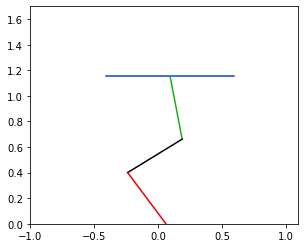

In [11]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

xmax = np.max([m.q[n,'x'].value for n in range(1,N+1)])
ymax = np.max([m.q[n,'y'].value for n in range(1,N+1)])

def plot_model(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,xmax+1]) # adjust limits to solution
    ax.set_ylim([0,ymax+0.5])
    
    #plot body
    body_xb = m.q[i,'x'].value - 0.5*m.len[('b')]*cos(m.q[i,'th1'].value)
    body_yb = m.q[i,'y'].value - 0.5*m.len[('b')]*sin(m.q[i,'th1'].value)
    body_xf = m.q[i,'x'].value + 0.5*m.len[('b')]*cos(m.q[i,'th1'].value)
    body_yf = m.q[i,'y'].value + 0.5*m.len[('b')]*sin(m.q[i,'th1'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:blue')
      
    #plot thigh
    thA = m.q[i,'th2'].value
    leg1_xt = m.q[i,'x'].value
    leg1_yt = m.q[i,'y'].value
    leg1_xb = m.q[i,'x'].value + m.len[('l1')]*sin(thA)
    leg1_yb = m.q[i,'y'].value - m.len[('l1')]*cos(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:green')
    
    #plot calf
    thB = m.q[i,'th3'].value
    leg2_xt = leg1_xb
    leg2_yt = leg1_yb
    leg2_xb = leg1_xb + m.len[('l2')]*sin(thB)
    leg2_yb = leg1_yb - m.len[('l2')]*cos(thB)
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')
    
    #plot foot
    thC = m.q[i,'th4'].value
    leg3_xt = leg2_xb
    leg3_yt = leg2_yb
    leg3_xb = leg2_xb + m.len[('l3')]*sin(thC)
    leg3_yb = leg2_yb - m.len[('l3')]*cos(thC)
    ax.plot([leg3_xt,leg3_xb],[leg3_yt,leg3_yb],color='xkcd:red')
    
update = lambda i: plot_model(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook
